## Table of Content
- Data Preprocessing
- Building Model
- Testing Model

## Data Preprocessing

#### Import Necessary Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import Xception, InceptionV3, VGG16
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import warnings

warnings.filterwarnings('ignore') 

In [9]:
# Assign paths
path = '/kaggle/input/intel-image-classification'
train_dir = path + '/seg_train/seg_train'
val_dir = path + '/seg_test/seg_test'
test_dir = path + '/seg_pred/seg_pred'

# Assign labels
labels = os.listdir(train_dir)
print(labels)

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


In [10]:
# Getting the total number of images in each class
tot = dict()
for label in labels:
    direc = train_dir + '/' + label
    tot[label] = len(os.listdir(direc))
print(tot)
min_sample = min(tot.values())
print(min_sample)

{'mountain': 2512, 'street': 2382, 'buildings': 2191, 'sea': 2274, 'forest': 2271, 'glacier': 2404}
2191


#### Visualizing random images in dataset

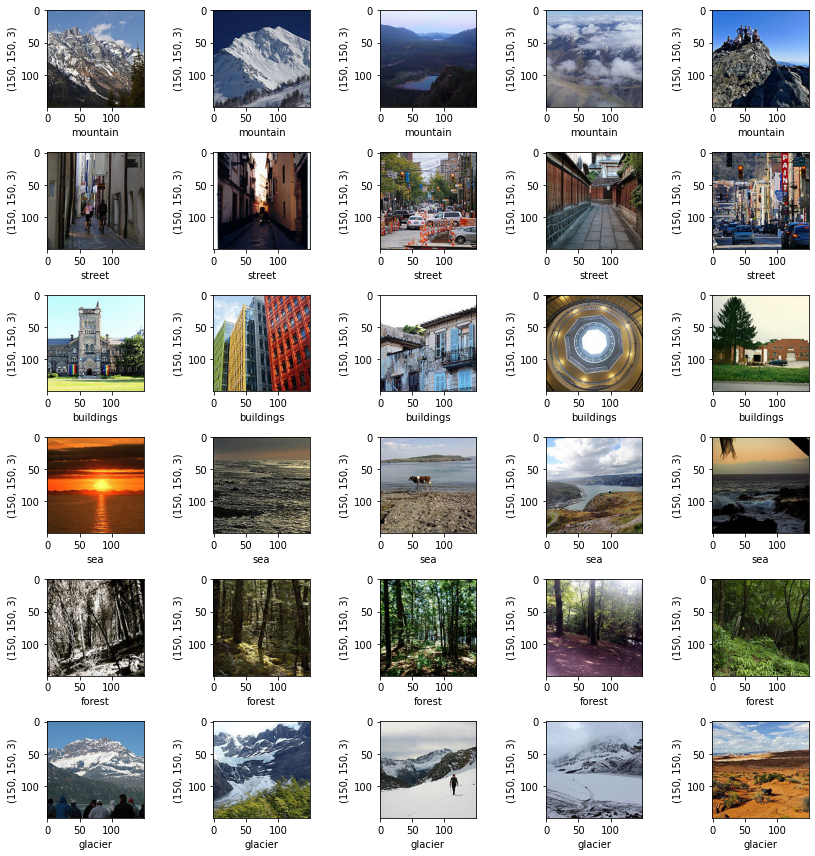

In [11]:
min_ = 1
max_ = 6
count = 0
plt.figure(figsize=(12, 12))
for label in labels:
    min_ += count
    max_ += count
    count = 5
    for i in range(min_, max_):
        path = train_dir + '/' + label
        plt.subplot(6, 5, i)
        plt.tight_layout()
        rand_img = plt.imread(path + '/' + random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img)
        # Plotting Dimensions of images
        plt.xlabel(label, fontsize=10)
        plt.ylabel(rand_img.shape, fontsize=10)

### Get train and validation generator

In [12]:
# Batch size
batch_size = 12

# Train Generator
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

# Validation generator
val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                   target_size=(150,150),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Building Model
> In this section we would build and evaluate pretrained models to calssify the Intel images.

In [13]:
k = len(labels)
print('Number of Classes:', k)

Number of Classes: 6


### Xception Model

In [14]:
# Building the Model
xcept = Xception(
    input_shape= (150, 150, 3),
    weights = 'imagenet',
    include_top = False
)
# Freeze pretrained model weights
xcept.trainable = False

# map date
x = Flatten()(xcept.output)
x = Dense(k, activation='softmax')(x)

xception = Model(inputs = xcept.input, outputs = x)

xception.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [15]:
steps_per_epoch = min_sample//batch_size

history = xception.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    verbose=1,
    validation_data = val_generator,
    validation_steps=steps_per_epoch
)

2022-09-21 20:51:58.071845: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-21 20:52:02.222182: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


182/182 [==============================] - 43s 180ms/step - loss: 0.4420 - accuracy: 0.8411 - val_loss: 0.3529 - val_accuracy: 0.8782
Epoch 2/20
182/182 [==============================] - 23s 125ms/step - loss: 0.3573 - accuracy: 0.8759 - val_loss: 0.3157 - val_accuracy: 0.8851
Epoch 3/20
182/182 [==============================] - 19s 107ms/step - loss: 0.2898 - accuracy: 0.8956 - val_loss: 0.3407 - val_accuracy: 0.8864
Epoch 4/20
182/182 [==============================] - 17s 95ms/step - loss: 0.2664 - accuracy: 0.9057 - val_loss: 0.3306 - val_accuracy: 0.8901
Epoch 5/20
182/182 [==============================] - 17s 91ms/step - loss: 0.2608 - accuracy: 0.9141 - val_loss: 0.3121 - val_accuracy: 0.8901
Epoch 6/20
182/182 [==============================] - 15s 84ms/step - loss: 0.2464 - accuracy: 0.9167 - val_loss: 0.4318 - val_accuracy: 0.8640
Epoch 7/20
182/182 [==============================] - 15s 83ms/step - loss: 0.2357 - accuracy: 0.9199 - val_loss: 0.2876 - val_accuracy: 0.8988


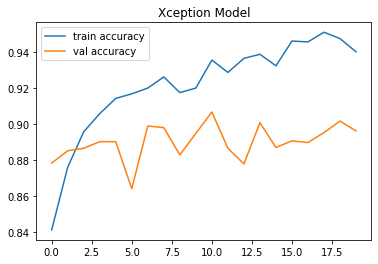

In [16]:
# Plot accouracy per iteration
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'val accuracy')
plt.title("Xception Model")
plt.legend()
plt.show()

### InceptionV3

In [17]:
# Building the Model
incept = InceptionV3(
    input_shape= (150, 150, 3),
    weights = 'imagenet',
    include_top = False
)
# Freeze pretrained model weights
incept.trainable = False

# map date
x = Flatten()(incept.output)
x = Dense(k, activation='softmax')(x)

inceptionV3 = Model(inputs = incept.input, outputs = x)

inceptionV3.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

inceptionV3.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 74, 74, 32)   96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_8[0][0]      
___________________________

In [18]:
steps_per_epoch = min_sample//batch_size

history = inceptionV3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    verbose=1,
    validation_data = val_generator,
    validation_steps=steps_per_epoch
)

Epoch 1/20
182/182 [==============================] - 21s 86ms/step - loss: 0.7056 - accuracy: 0.7697 - val_loss: 0.4987 - val_accuracy: 0.8420
Epoch 2/20
182/182 [==============================] - 13s 70ms/step - loss: 0.5010 - accuracy: 0.8384 - val_loss: 0.4892 - val_accuracy: 0.8429
Epoch 3/20
182/182 [==============================] - 13s 72ms/step - loss: 0.3747 - accuracy: 0.8869 - val_loss: 0.3938 - val_accuracy: 0.8713
Epoch 4/20
182/182 [==============================] - 13s 71ms/step - loss: 0.3498 - accuracy: 0.8884 - val_loss: 0.3513 - val_accuracy: 0.8864
Epoch 5/20
182/182 [==============================] - 13s 72ms/step - loss: 0.3735 - accuracy: 0.8768 - val_loss: 0.4185 - val_accuracy: 0.8672
Epoch 6/20
182/182 [==============================] - 12s 69ms/step - loss: 0.3260 - accuracy: 0.8915 - val_loss: 0.4858 - val_accuracy: 0.8613
Epoch 7/20
182/182 [==============================] - 13s 72ms/step - loss: 0.3104 - accuracy: 0.8956 - val_loss: 0.3654 - val_accuracy:

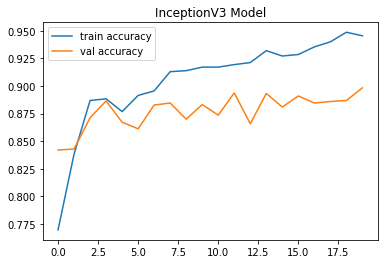

In [19]:
# Plot accouracy per iteration
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'val accuracy')
plt.title("InceptionV3 Model")
plt.legend()
plt.show()

### VGG16

In [20]:
# Building the Model
vgg16 = VGG16(
    input_shape= (150, 150, 3),
    weights = 'imagenet',
    include_top = False
)
# Freeze pretrained model weights
vgg16.trainable = False

# map date
x = Flatten()(vgg16.output)
x = Dense(k, activation='softmax')(x)

vgg16_model = Model(inputs = vgg16.input, outputs = x)

vgg16_model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________________

In [21]:
steps_per_epoch = min_sample//batch_size

history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    verbose=1,
    validation_data = val_generator,
    validation_steps=steps_per_epoch
)

Epoch 1/20
182/182 [==============================] - 13s 63ms/step - loss: 1.1432 - accuracy: 0.6377 - val_loss: 0.7840 - val_accuracy: 0.7724
Epoch 2/20
182/182 [==============================] - 11s 63ms/step - loss: 0.6751 - accuracy: 0.7885 - val_loss: 0.5862 - val_accuracy: 0.8191
Epoch 3/20
182/182 [==============================] - 11s 60ms/step - loss: 0.5601 - accuracy: 0.8274 - val_loss: 0.5523 - val_accuracy: 0.8114
Epoch 4/20
182/182 [==============================] - 12s 64ms/step - loss: 0.4998 - accuracy: 0.8219 - val_loss: 0.4733 - val_accuracy: 0.8480
Epoch 5/20
182/182 [==============================] - 11s 58ms/step - loss: 0.4428 - accuracy: 0.8516 - val_loss: 0.4488 - val_accuracy: 0.8526
Epoch 6/20
182/182 [==============================] - 11s 58ms/step - loss: 0.4335 - accuracy: 0.8494 - val_loss: 0.4392 - val_accuracy: 0.8484
Epoch 7/20
182/182 [==============================] - 11s 60ms/step - loss: 0.4114 - accuracy: 0.8663 - val_loss: 0.4103 - val_accuracy:

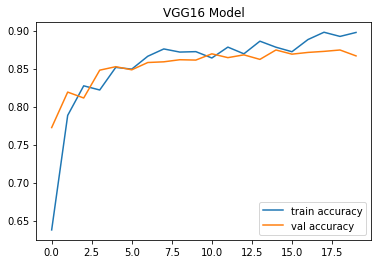

In [22]:
# Plot accouracy per iteration
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'val accuracy')
plt.title("VGG16 Model")
plt.legend()
plt.show()

### Comparing Results

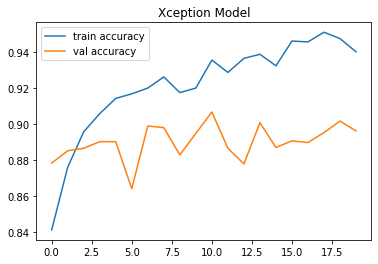

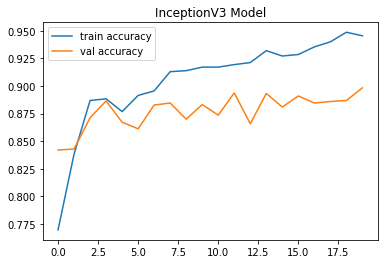

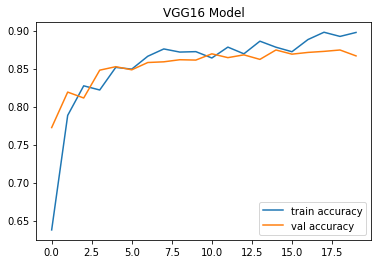

**INSIGHT:** From the above, you can deduce that `Xception model` has a slighly higher validation score than InceptionV3 and VGG16

### Saving Model
> Here, we would save the best model which is the xception model

In [23]:
xception.save('intel_image.h5')

## Testing Model
> The dataset used here were dowloaded from several site via google search.

In [2]:
# loading the model
model = load_model('intel_image.h5')

In [3]:
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

### Visual Evaluation

1/1 [==============================] - 0s 75ms/step


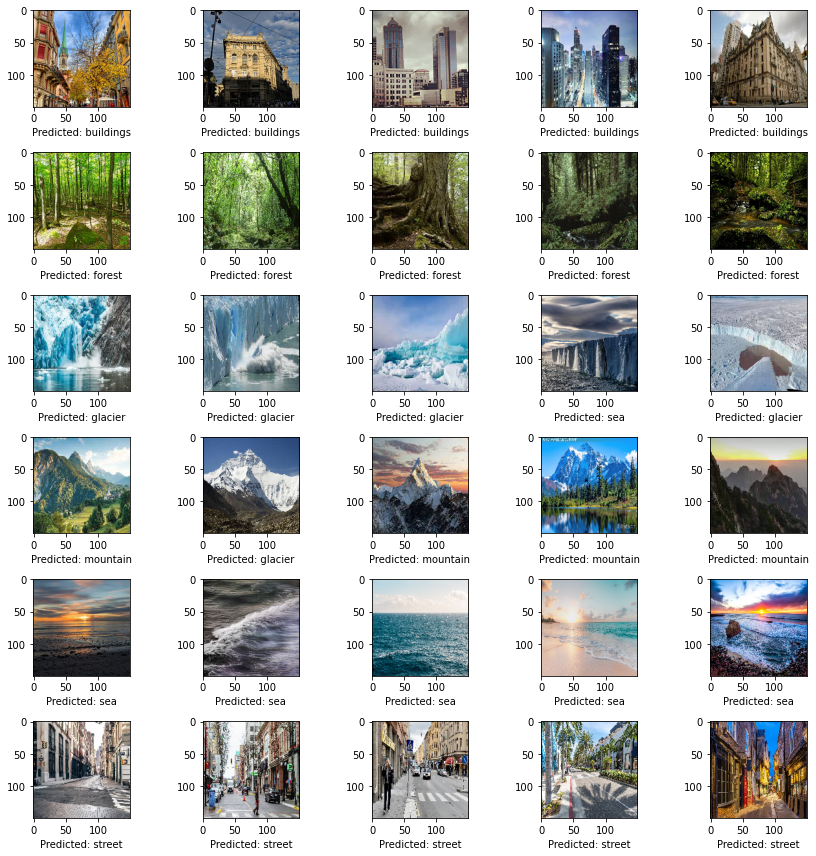

In [4]:
min_ = 1
max_ = 6
count = 0
plt.figure(figsize=(12, 12))
for label in labels:
    min_ += count
    max_ += count
    count = 5
    k=0
    for i in range(min_, max_):
        path = 'test/' + label
        plt.subplot(6, 5, i)
        plt.tight_layout()
        img = load_img(path + '/' + sorted(os.listdir(path))[k], target_size=(150, 150))
        
        # converting image to numpy array
        img_arr = img_to_array(img)
        X = np.expand_dims(img_arr.copy(),axis = 0)
        
        
        # normalizing dataset
        X = X/255.0
        k+=1
        
        # make predictions
        pred = np.argmax(model.predict(X))
        result = labels[pred]
        
        plt.imshow(img)
        # Plotting labels on images
        # plt.ylabel('True label: {}'.format(label), fontsize=10)
        plt.xlabel('Predicted: {}'.format(result), fontsize=10);

- The model misclassified a mountain as glacier which makes alot of sense because this particular mountain has glacier on the top.
- The model also misclassified a glacier as sea and again this made sense because this particular image was a glacier in the middle of the sea.

### From the above, we can see that the model has done very well in classifying the images 